In [108]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, Subset
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from UtilityGraph import *
from Defence import *
from Corruption import *
from UtilityMLP import *
import random
import copy
import itertools
from Test import *
from ipywidgets import interact, IntSlider
import copy

# Device configuration (use GPU if available)
device = torch.device('cuda')
# %matplotlib notebook
%matplotlib widget

In [109]:
Seed = 42  # for reproducibility
random.seed(Seed)
np.random.seed(Seed) 
torch.manual_seed(Seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(Seed)
    torch.cuda.manual_seed_all(Seed)

# Graph
required_probability=0.9999
Amount_Clients = 20
num_nodes, G,A,pos,r_c=build_random_graph(Amount_Clients,required_probability,fix_num_nodes=True)


In [110]:
print("num_nodes:",num_nodes)

# Hyperparameters
input_size = 28 * 28        # MNIST images are 28x28 pixels
hidden_size = 128           # Number of neurons in the hidden layer
num_classes = 10            # Number of output classes (digits 0-9)
num_epochs = 5             # Number of local training epochs per aggregation 
batch_size = 64             # Batch size for training
learning_rate = 0.01        # Learning rate for the optimizer
num_clients = num_nodes     # Number of clients 
num_rounds = 1              # Number of aggregation rounds
threshold = 0.02            # Loss threshold for stopping criteria

percentageCorrupt = 0/num_nodes        #Percentage of corrupt clients
corrupt = True              #If True, corrupt clients are included
CorruptClients = CorruptGeneration(percentageCorrupt, corrupt, num_clients) #Selection of Corrupt Clients

lying_nodes = 0
lying_nodes = np.where(CorruptClients == 1)[0]
true_nodes = [i for i in range(num_nodes) if i not in lying_nodes]

all_nodes = np.union1d(lying_nodes, true_nodes)
print("Corrupt Clients:", lying_nodes)
tolerance=-1                #PDMM tolerance
c=0.5                       #PDMM c
max_iters=500             #PDMM max iterations
when = 0
CorruptValue = -100000000000000000

rejection_threshold = 20**20
K_decision = 5
averaging = 1
noise_levels = [0]
# noise_levels = [0, 1] 
# noise_levels = [0, 10**-2,1,10**2,10**4] 
# noise_levels = [0, 10**-6,10**-4,10**-2,1] 
# noise_levels = [10**4, 10**8, 10**16] 

var = 10                  # Standard deviation for Gaussian noise
mean = 10**8                   # Mean for Gaussian noise
Target = np.random.randint(1, num_clients) # Target client for copycat attack
scale = 0
typeAttack = 6              # 0: Label Flipping attack, 1: Gaussian noise, 2: Copycat attack, 3: Gaussian addative noise attack, 4: LIE attack, 5 Sign flip attack, 6: No attack
PrivacyMethod = 0       # 0: No privacy, 1: DP, 2: SMPC, 3: Subspace
# PrimModulo = [2**32 - 5, 2**32 - 5, 2**61 - 1] # Prime number for SMPC should be above sum of all client local model values
PrimModulo = [0]

neighbors_dict = {}
for ln in lying_nodes:
    neighbors_dict[ln] = list(G.neighbors(ln))
save = False
print("Neighbors of lying nodes:", neighbors_dict)

num_nodes: 20
IteNumber of Corrupt nodesration 0, Corrupt nodes: []
Corrupt Clients: []
Neighbors of lying nodes: {}


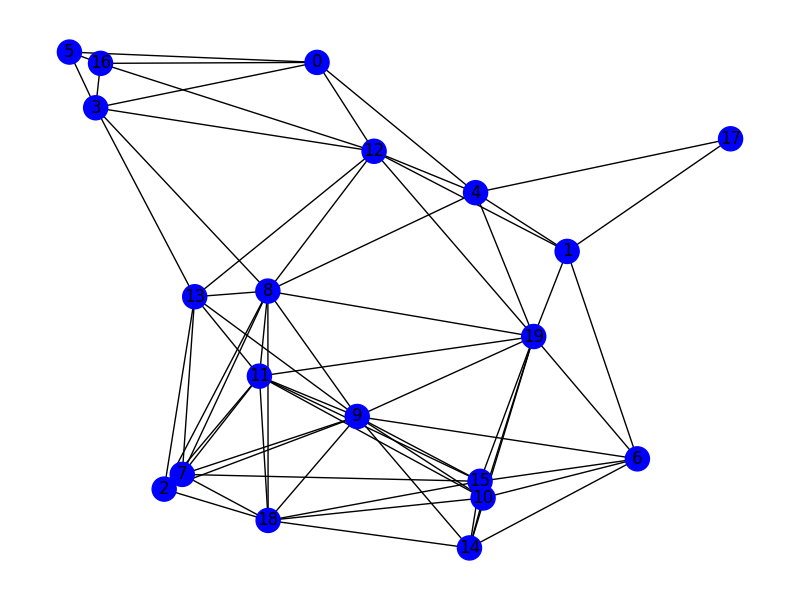

Are the honest‐only nodes still forming a connected subgraph? True
Are all honest nodes connected to a majority of honest neighbors? True


In [111]:
plt.figure(figsize=(8,6))
color_map = []
for node in range(num_nodes):
    if node in lying_nodes:
        color_map.append('red')   # corrupt
    else:
        color_map.append('blue')  # honest

nx.draw(G, pos, with_labels=True, node_color=color_map)
plt.title("Graph with Lying (Red) and Honest (Blue) Nodes")
plt.show()

# Create a subgraph containing only honest nodes
remaining_nodes = [n for n in G.nodes() if n not in lying_nodes]
G_sub = G.subgraph(remaining_nodes)

still_connected = nx.is_connected(G_sub)
print("Are the honest‐only nodes still forming a connected subgraph?", still_connected)

# Check that every honest node has a majority of honest neighbors
all_honest = [n for n in G.nodes() if n not in lying_nodes]
all_good = True  # Flag to track if all honest nodes pass the check

for node in all_honest:
    neighbors = list(G.neighbors(node))
    total_neighbors = len(neighbors)
    # Count honest neighbors (neighbors that are not in lying_nodes)
    honest_neighbors = sum(1 for neighbor in neighbors if neighbor not in lying_nodes)
    
    # Only check nodes that have at least one neighbor; if a node is isolated, it might need special handling
    if total_neighbors > 0:
        if honest_neighbors <= total_neighbors / 2:
            print(f"Honest node {node} does not have majority honest neighbors: {honest_neighbors} honest out of {total_neighbors} neighbors")
            all_good = False
            
print("Are all honest nodes connected to a majority of honest neighbors?", all_good)

In [112]:
def plot_combined_metrics(results, round, typeAttack, PrivacyMethod,save):
    # Define markers for different sigma values
    markers = ['o', 's', 'd', '^', 'v', '<', '>', 'p', '*', 'h', '+', 'x']
    
    # Group results by noise level
    noise_groups = {}
    for res in results:
        if PrivacyMethod == 2:
            key = 0
        else:
            # use .get so missing keys map to 0
            key = res.get('noise_STD', 0) or 0
        noise_groups.setdefault(key, []).append(res)

    # Create plots
    fig, axs = plt.subplots(3, 1, figsize=(10, 8))

    # Convert noise levels to sorted list for consistent markers
    sorted_noises = sorted(noise_groups.keys())

    # Define base sparsity (every N points)
    base_markevery = 17  
    
    # Plot FAR
    for idx, noise in enumerate(sorted_noises):
        group = noise_groups[noise]
        far_matrix = np.array([res['FAR'] for res in group])
        avg_far = np.mean(far_matrix, axis=0)
        marker = markers[idx % len(markers)]  # Cycle through markers
        offset = (idx*50) % base_markevery  # Offset to stagger marker placement
        markevery = (offset, base_markevery)  # Staggered marker appearance
        if PrivacyMethod != 2:
            if noise != 0:
                axs[0].plot(avg_far, marker=marker, markevery=markevery, label=f'$\\sigma^2 = 10^{{{int(np.log10(noise))}}}$', markersize=6)
            else:
                axs[0].plot(avg_far, marker=marker, markevery=markevery, label='$\\sigma^2 = 0$', markersize=6)
        if PrivacyMethod == 2:
            axs[0].plot(avg_far, marker=marker, markevery=markevery, markersize=6)
    axs[0].set_title(f'False Alarm Rate (Round {round})')
    axs[0].set_ylabel('FAR')
    axs[0].grid(True)
    
    # Plot MDR
    for idx, noise in enumerate(sorted_noises):
        group = noise_groups[noise]
        mdr_matrix = np.array([res['MDR'] for res in group])
        avg_mdr = np.mean(mdr_matrix, axis=0)
        marker = markers[idx % len(markers)]
        offset = (idx*50) % base_markevery
        markevery = (offset, base_markevery)
        if PrivacyMethod != 2:
            if noise != 0:
                axs[1].plot(avg_mdr, marker=marker, markevery=markevery, label=f'$\\sigma^2 = 10^{{{int(np.log10(noise))}}}$', markersize=6)
            else:
                axs[1].plot(avg_mdr, marker=marker, markevery=markevery, label='$\\sigma^2 = 0$', markersize=6)
        if PrivacyMethod == 2:
                axs[1].plot(avg_mdr, marker=marker, markevery=markevery , markersize=6)
    axs[1].set_title(f'Missed Detection Rate (Round {round})')
    axs[1].set_ylabel('MDR')
    axs[1].grid(True)

    # Plot Error
    for idx, noise in enumerate(sorted_noises):
        group = noise_groups[noise]
        err_matrix = np.array([res['Error'] for res in group])
        avg_err = np.mean(err_matrix, axis=0)
        marker = markers[idx % len(markers)]
        offset = (idx*50) % base_markevery
        markevery = (offset, base_markevery)
        if PrivacyMethod != 2:
            if noise != 0:
                axs[2].plot(avg_err, marker=marker, markevery=markevery, label=f'$\\sigma^2 = 10^{{{int(np.log10(noise))}}}$', markersize=6)
            else:
                axs[2].plot(avg_err, marker=marker, markevery=markevery, label='$\\sigma^2 = 0$', markersize=6)
        if PrivacyMethod == 2:
            axs[2].plot(avg_err, marker=marker, markevery=markevery, markersize=6)
    axs[2].set_title(f'Consensus Error (Round {round})')
    axs[2].set_ylabel('Error')
    axs[2].set_xlabel('Iteration')
    axs[2].set_yscale('log')
    axs[2].grid(True)
    if PrivacyMethod != 2:
        axs[2].legend()  # Add legend for the third plot
    plt.tight_layout()
    if save == True:
        filename = f"combined_metrics_typeAttack{typeAttack}_PrivacyMethod{PrivacyMethod}_Round{round}.png"
        plt.savefig(filename, dpi=300)
    plt.show()


In [113]:
# Define the -layer MLP model
class Current(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Current, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # First fully connected layer
        self.relu = nn.ReLU()                          # ReLU activation function
        self.fc2 = nn.Linear(hidden_size, num_classes) # Second fully connected layer

    def forward(self, x):
        x = x.view(-1, input_size)  # Flatten the input tensor
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out


In [114]:
# class Current(nn.Module):
#     def __init__(self, input_size, hidden_size, num_classes):
#         super(Current, self).__init__()
        
#         self.layers = nn.Sequential(
#             nn.Linear(input_size, hidden_size),  # Layer 1
#             nn.ReLU(),
#             nn.Linear(hidden_size, hidden_size), # Layer 2
#             nn.ReLU(),
#             nn.Linear(hidden_size, hidden_size), # Layer 3
#             nn.ReLU(),
#             nn.Linear(hidden_size, hidden_size), # Layer 4
#             nn.ReLU(),
#             nn.Linear(hidden_size, hidden_size), # Layer 5
#             nn.ReLU(),
#             nn.Linear(hidden_size, hidden_size), # Layer 6
#             nn.ReLU(),
#             nn.Linear(hidden_size, num_classes)  # Output Layer (Layer 7)
#         )

#     def forward(self, x):
#         x = x.view(x.size(0), -1)  # Flatten the input
#         return self.layers(x)


In [115]:
# class Current(nn.Module):
#     def __init__(self, input_size, hidden_size, num_classes):
#         super(Current, self).__init__()
#         # First convolution: input 1 channel, output 32 channels, 3x3 kernel, stride 1
#         self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1)
#         # Second convolution: input 32 channels, output 64 channels, 3x3 kernel, stride 1
#         self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1)
#         # Max pooling with a 2x2 kernel (default stride is kernel_size)
#         self.pool = nn.MaxPool2d(kernel_size=2)
#         # Dropout before flattening with p=0.25
#         self.dropout1 = nn.Dropout(p=0.25)
#         # Fully connected layer: input dimension is 64 channels * 12 * 12 = 9216, output is 128
#         self.fc1 = nn.Linear(in_features=64 * 12 * 12, out_features=128)
#         # Dropout after first FC with p=0.5
#         self.dropout2 = nn.Dropout(p=0.5)
#         # Final fully connected layer: 128 -> 10 classes
#         self.fc2 = nn.Linear(in_features=128, out_features=10)

#     def forward(self, x):
#         # x is expected to be of shape (batch_size, 1, 28, 28)
#         # First conv + ReLU: output shape (batch_size, 32, 26, 26)
#         x = F.relu(self.conv1(x))
#         # Second conv + ReLU: output shape (batch_size, 64, 24, 24)
#         x = F.relu(self.conv2(x))
#         # Max pooling: output shape (batch_size, 64, 12, 12)
#         x = self.pool(x)
#         # Apply dropout then flatten the tensor to (batch_size, 9216)
#         x = self.dropout1(x)
#         x = torch.flatten(x, 1)
#         # First fully connected layer + ReLU: output shape (batch_size, 128)
#         x = F.relu(self.fc1(x))
#         # Apply second dropout
#         x = self.dropout2(x)
#         # Final fully connected layer: output shape (batch_size, 10)
#         x = self.fc2(x)
#         return x


In [116]:
# ------------------------------------------------------------------
# One-time weight template – every client will start from these weights
# ------------------------------------------------------------------
init_weights = Current(input_size, hidden_size, num_classes).state_dict()


In [117]:
def split_dataset(dataset, num_clients):
    dataset_size = len(dataset)
    indices = np.random.permutation(dataset_size)  # Shuffle all indices
    data_per_client = dataset_size // num_clients
    split_sizes = [data_per_client] * num_clients

    # Distribute any remaining data among the first few clients
    for i in range(dataset_size % num_clients):
        split_sizes[i] += 1

    datasets = []
    start = 0
    for size in split_sizes:
        datasets.append(Subset(dataset, indices[start:start + size]))
        start += size  # Move the start index forward

    return datasets

In [118]:
# def train_local_model(dataset, global_model, num_epochs):
#     """Train a local model initialized with global weights"""
#     model =  type(global_model)(input_size, hidden_size, num_classes).to(device)
#     model.load_state_dict(global_model.state_dict()) 
#     model.train()
    
#     train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
#     criterion = nn.CrossEntropyLoss()
#     optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
#     grad_dict = None 
#     for epoch in range(num_epochs):
#         running_loss = 0.0
#         for images, labels in train_loader:
#             images = images.to(device)
#             labels = labels.to(device)

#             # Forward pass
#             outputs = model(images)
#             loss = criterion(outputs, labels)

#             # Backward and optimize
#             optimizer.zero_grad()
#             loss.backward()
#             grad_dict = {name: p.grad.detach().clone()
#                          for name, p in model.named_parameters()
#                          if p.grad is not None}
#             optimizer.step()

#             running_loss += loss.item()

#         avg_loss = running_loss / len(train_loader)
#         print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')
#         #params = list(model.parameters())

#     return model, grad_dict

In [119]:
# def aggregate_models2(local_models, input_size, hidden_size, num_classes, num_nodesSelected):
#     """
#     Compute the averaged model parameters from local models and return a new model.

#     Args:
#         local_models (list): List of PyTorch models (local models).
#         input_size (int): Input size for the model.
#         hidden_size (int): Hidden layer size.
#         num_classes (int): Number of output classes.

#     Returns:
#         torch.nn.Module: A new model with averaged parameters.
#     """
#     # Extract state_dicts from local models
#     local_dicts = [model.state_dict() for model in local_models]

#     # Initialize global_dict with zero tensors of the same shape as the first model's parameters
#     global_dict = {key: torch.zeros_like(local_dicts[0][key]) for key in local_dicts[0].keys()}

#     # Compute the average over all local models
#     for key in global_dict.keys():
#         global_dict[key] = sum(local_dicts[i][key] for i in num_nodesSelected) / len(num_nodesSelected)

#     averaged_model = type(local_models[0])(input_size, hidden_size, num_classes).to(device)  
#     averaged_model.load_state_dict(global_dict)

#     return averaged_model


In [120]:
def aggregate_models(client_datasets, node_models, G, tolerance, c, max_iters, rejection_threshold, K_decision, averaging, when, CorruptValue, true_nodes, Print_Val, noise_STD, PrivacyMethod, p, learning_rate, perm_threshold=0.5):
    # Initialize variables
    num_nodes = len(node_models)
    converged = False
    count = 0
    Error = []
    Track = 0
    mask_history = []
    # lying_nodes = lying_nodes or set()
    global_dict = node_models[0].state_dict() 
    True_avg_dict = global_dict
    # True_avg_dict = True_avg.state_dict()
    iters = [iter(DataLoader(ds, batch_size=batch_size, shuffle=True, drop_last=True)) for ds in client_datasets]

    # Detection 
    mask = np.ones((num_nodes, num_nodes), dtype=int)  # 1: active, -1: blocked
    D = {i: {j: 0 for j in G.neighbors(i)} for i in G.nodes()}  # Suspicion scores
    ignored = {i: set() for i in G.nodes()}  # Ignored neighbors

    # Model parameter initialization
    local_dicts = [model.state_dict() for model in node_models]

    # param_keys = True_avg.keys()  # all models have the same parameters
    A_ij = calc_incidence_nested(G)
    x_history = []
    # Initialize PDMM variables with tensor support
    x = [{} for _ in range(num_nodes)]
    z = [{} for _ in range(num_nodes)]
    y = [{} for _ in range(num_nodes)]
    y_transmit = [{} for _ in range(num_nodes)]
    # Initialize x with local models and move to device
    for i in range(num_nodes):
        for key in True_avg_dict.keys():
                x[i][key] = local_dicts[i][key].clone()

    # Initialize z and y
    for i in range(num_nodes):
        z[i] = {}
        y[i] = {}
        y_transmit[i] = {}
        for j in G.neighbors(i):
            z[i][j] = {}
            y[i][j] = {}
            y_transmit[i][j] = {}
            for key in True_avg_dict.keys():
                if PrivacyMethod == 3:
                    z[i][j][key] = torch.randn_like(True_avg_dict[key]) * noise_STD
                else:
                    z[i][j][key] = torch.zeros_like(True_avg_dict[key])
                y[i][j][key] = torch.zeros_like(True_avg_dict[key])
                y_transmit[i][j][key] = torch.zeros_like(True_avg_dict[key])
         
    if PrivacyMethod == 2:
        smpc_masks = {}
        for i in range(num_nodes):
            for j in G.neighbors(i):
                if i < j:
                    smpc_masks[(i, j)] = {}
                    for key in True_avg_dict:
                        smpc_masks[(i, j)][key] = torch.randn_like(True_avg_dict[key])

    # print(lying_nodes)
    # Synchronous PDMM with detection
    while not converged and count < max_iters:

        # -------------------------------------------------
        # 0) fresh local gradients g_i
        # -------------------------------------------------
        g = [{} for _ in range(num_nodes)]
        for i, model in enumerate(node_models):
            try:
                xb, yb = next(iters[i])
            except StopIteration:
                iters[i] = iter(DataLoader(client_datasets[i], batch_size=batch_size,
                                           shuffle=True, drop_last=True))
                xb, yb = next(iters[i])

            xb, yb = xb.to(device), yb.to(device)
            loss   = F.cross_entropy(model(xb), yb)
            model.zero_grad()
            loss.backward()
            for n, p in model.named_parameters():
                g[i][n] = p.grad.detach().clone()

        # --------------------
        # 1. Synchronous x-update for all nodes
        # --------------------
        x_new = [{} for _ in range(num_nodes)]
        for i in range(num_nodes):
            # Count corrupt neighbors once for node i
            corrupt_neighbors = sum(1 for j in G.neighbors(i) if mask[i][j] == -1)
            effective_degree = G.degree[i] - corrupt_neighbors

            # Update each parameter using the same effective degree
            for key in True_avg_dict:
                num = local_dicts[i][key] - learning_rate * g[i][key]
                for j in G.neighbors(i):
                    if mask[i][j] != -1:
                        num -= A_ij[i][j] * z[i][j][key]
                den = 1.0 + c * effective_degree 
                x_new[i][key] = num / den
        x = x_new
        x_history.append(x.copy())

        # ---- Sync torch modules and local_dicts with the fresh PDMM solution ----
        for i in range(num_nodes):
            # build a plain state-dict for loading
            new_state = {k: v.clone() for k, v in x[i].items()}
            node_models[i].load_state_dict(new_state)   # so next gradient is ∇F(w_i^{(k)})
            local_dicts[i] = new_state                  # num = w_i^{(k)} - α g_i^{(k)}
        # ------------------------------------------------------------------------


        # --------------------
        # 2. Dual variable update (y)
        # --------------------
        for i in range(num_nodes):
            for j in G.neighbors(i):
                for key in True_avg_dict:
                    y[i][j][key] = z[i][j][key] + 2 * c * A_ij[i][j] * x[i][key]
                    if PrivacyMethod == 1:
                        y[i][j][key] = y[i][j][key].clone() + torch.randn_like(local_dicts[i][key]) * noise_STD

        if PrivacyMethod == 2:
            # SMPC: Apply pairwise masks for secure aggregation
            for i in range(num_nodes):
                for j in G.neighbors(i):
                    if mask[i][j] == -1:
                        for key in True_avg_dict:
                            y_transmit[i][j][key] = torch.zeros_like(y[i][j][key])
                    else:
                        for key in True_avg_dict:
                            if i < j:
                                y_transmit[i][j][key] = y[i][j][key] + smpc_masks[(i, j)][key]
                            else:
                                y_transmit[i][j][key] = y[i][j][key] - smpc_masks[(j, i)][key]
        else:
            # Original: no additional masking
            for i in range(num_nodes):
                for j in G.neighbors(i):
                    if mask[i][j] == -1:
                        for key in True_avg_dict:
                            y_transmit[i][j][key] = torch.zeros_like(y[i][j][key])
                    else:
                        for key in True_avg_dict:
                            y_transmit[i][j][key] = y[i][j][key].clone()


        # --------------------
        # 3. Detection logic (executed periodically)
        # --------------------
        # if count > when:
        print(f"Detecting at count {count}")
        for i in range(num_nodes):
            neighbors = [j for j in G.neighbors(i) if j not in ignored[i]]
            if not neighbors:
                continue

            # Precompute absolute values of y variables (for PDMM minus-sign handling)
            abs_y = {j: {key: torch.abs(y_transmit[j][i][key]) for key in True_avg_dict} for j in neighbors}

            # 1. Compute element-wise median (m_i)
            medians = {}
            for key in True_avg_dict:
                # Stack all neighbors' parameters for this key
                params = torch.stack([abs_y[j][key] for j in neighbors])
                medians[key] = torch.median(params, dim=0).values  # Element-wise median

            # 2. Compute Delta Y_{i,j} using infinity norm
            delta_ys = []
            for j in neighbors:
                max_diff = -float('inf')
                for key in True_avg_dict:
                    diff = torch.max(torch.abs(abs_y[j][key] - medians[key])).item()
                    if diff > max_diff:
                        max_diff = diff
                delta_ys.append(max_diff)

            # 3. Compute MAD and threshold
            median_delta = np.median(delta_ys)
            deviations = np.abs(delta_ys - median_delta)
            MAD_val = np.median(deviations)
            threshold = rejection_threshold * MAD_val
            epsilon = 1e-2  
            threshold = max(threshold, epsilon) # TO avaoid zero threshold

            # 4. Update suspicion scores
            for idx, j in enumerate(neighbors):
                # if j in lying_nodes:
                # print(f"Node {i} check {j}: ΔY={delta_ys[idx]:.2f}, threshold={threshold:.2f}")
                if delta_ys[idx] > threshold:
                    print(f"To {i} Value of {j}: ΔY={delta_ys[idx]:.2f}, threshold={threshold:.2f}, D = {D[i][j]}")
                # if j in lying_nodes:
                    D[i][j] += 1
                    # if Print_Val:
                    # print(f"Node {i} suspicious of {j}: ΔY={delta_ys[idx]:.2f}, threshold={threshold:.2f}, D = {D[i][j]}")

            # 5. Periodic mitigation check
            if count % K_decision == 0 and count > 0:
                for j in list(D[i].keys()):  # Iterate over copy to allow modification
                    if D[i][j] > K_decision/2:
                        # print(f"Node {i} ignoring node {j} for next {K_decision} iterations")
                        mask[i][j] = -1
                    else:
                        mask[i][j] = 1
                    D[i][j] = 0
        mask_history.append(mask.copy())

        # Next, update z values based on received y_transmit (unmask for SMPC)
        if PrivacyMethod == 2:
            for i in range(num_nodes):
                for j in G.neighbors(i):
                    if mask[i][j] == -1:
                        for key in True_avg_dict:
                            z[i][j][key] = (1 - averaging) * z[i][j][key]
                    if mask[i][j] == 1:
                        for key in True_avg_dict:
                            # Receive from neighbor j to i: unmask the value
                            if j < i:
                                unmasked = y_transmit[j][i][key] + smpc_masks[(j, i)][key]
                            else:
                                unmasked = y_transmit[j][i][key] - smpc_masks[(i, j)][key]
                            z[i][j][key] = (1 - averaging) * z[i][j][key] + (averaging) * unmasked
        else:
            for i in range(num_nodes):
                for j in G.neighbors(i):
                    if mask[i][j] == -1:
                        for key in True_avg_dict:
                            z[i][j][key] = (1 - averaging) * z[i][j][key]
                    if mask[i][j] == 1:
                        for key in True_avg_dict:
                            z[i][j][key] = (1 - averaging) * z[i][j][key] + (averaging) * y_transmit[j][i][key].clone()


        # --------------------
        # 4. Synchronous z-update with masking
        # --------------------
        for i in range(num_nodes):
            for j in G.neighbors(i):
                if mask[i][j] == -1:
                    # Block transmissions for each parameter in y[i][j]
                    for key in True_avg_dict:
                        # Just set it to zero (same shape)
                        y_transmit[i][j][key] = torch.zeros_like(y[i][j][key])
                else:
                    # Pass the full dictionary
                    for key in True_avg_dict:
                        y_transmit[i][j][key] = y[i][j][key].clone()

        for i in range(num_nodes):
            for j in G.neighbors(i):
                if mask[i][j] == -1:
                    # Apply noise to blocked channels
                    for key in True_avg_dict:
                        z[i][j][key] = (1 - averaging) * z[i][j][key] 
                        # if torch.norm(z[i][j][key]) == 0:
                        #     print("Pizza")
                if mask[i][j] == 1:
                    # Normal update from y values
                    for key in True_avg_dict:
                        z[i][j][key] = (1 - averaging) * z[i][j][key]  + (averaging) * y_transmit[j][i][key].clone()

        # --------------------
        # 5. Update global model and check convergence
        # --------------------
        avg_error = 0
        err_i = 0
        total_elements = 0

        for i in true_nodes:
            node_error = 0
            for key in True_avg_dict:
                diff = x[i][key] - True_avg_dict[key]
                norm_diff = torch.norm(diff).item()**2
                node_error += norm_diff
            err_i += node_error
            avg_error = err_i**0.5
            total_elements += 1

        # Final norm: average error divided by the total number of nodes
        avg_error /= total_elements

        # Store the computed average error
        Error.append(avg_error)
        print(f"cunt {count} and error {Error[-1]}" )

        if avg_error < tolerance:
            print(f'Converged at iteration {count}')
            converged = True
        elif count % 10 == 0 and Print_Val:
            print(f'Iter {count}: Error {avg_error:.4f}')

        # Update parameters for next iteration
        count += 1
    # Update final models
    for i in range(num_nodes):
        model_dict = node_models[i].state_dict()
        for key in True_avg_dict:
            model_dict[key] = x[i][key].clone()
        node_models[i].load_state_dict(model_dict)

    # Create an averaged model with the final True_avg_dict
    averaged_model = type(node_models[0])(input_size, hidden_size, num_classes).to(device)  # Pass necessary arguments directly
    averaged_model.load_state_dict(True_avg_dict)


    return node_models, Error, mask_history

In [121]:
def evaluate(models, test_dataset, criterion):
    """Evaluate either a single model or list of models"""

    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
    
    if not isinstance(models, (list, tuple)):
        models = [models]
    avg_loss = 0.0
    avg_accuracy = 0.0
    
    for model in models:
        model.to(device)  # Move model to the correct device
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            running_loss = 0.0
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            avg_loss += running_loss / len(test_loader)
            avg_accuracy += 100 * correct / total

    # Average across all models
    avg_loss /= len(models)
    avg_accuracy /= len(models)
    return avg_loss, avg_accuracy

In [122]:
# EMNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),                      
    transforms.Normalize((0.1307,), (0.3081,)) # Normalize the pixel values 
])


# Download the FashionMNIST dataset
train_dataset = torchvision.datasets.FashionMNIST(
    root='./data', train=True, transform=transform, download=True
)
test_dataset = torchvision.datasets.FashionMNIST(
    root='./data', train=False, transform=transform, download=True
)


class FlipLabelDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.label_map = {
            0: 3,
            1: 4,
            2: 7,
            3: 5,
            4: 8,
            5: 0,
            6: 9,
            7: 6,
            8: 2,
            9: 1
        }

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        flipped_label = self.label_map[label]
        return image, flipped_label

# Split the training dataset into subsets for each client
client_datasets = split_dataset(train_dataset, num_clients)

# Flip labels for corrupt clients (AFTER splitting)
for client_idx in lying_nodes:
    print(f"fliiping labels for client {client_idx}")
    original_dataset = client_datasets[client_idx]
    if typeAttack != 6:
        client_datasets[client_idx] = FlipLabelDataset(original_dataset)

trainable_model = [None] * num_clients

for client_idx in range(num_clients):
    # Initialize the  model
    trainable_model[client_idx] = Current(input_size, hidden_size, num_classes).to(device)
    trainable_model[client_idx].train()

local_intialized_models = []

for _ in range(num_clients):
    m = Current(input_size, hidden_size, num_classes).to(device)
    m.load_state_dict(init_weights)         
    m.train()
    local_intialized_models.append(m)


# Loss and optimizer (used for evaluation on the test set)
criterion = nn.CrossEntropyLoss()


--- Doing noise level 0 with 1 rounds---

--- Round 1 of 1 ---
Detecting at count 0
cunt 0 and error 0.1350126736349487
Detecting at count 1
cunt 1 and error 0.14738630845966197
Detecting at count 2
cunt 2 and error 0.12455319979334287
Detecting at count 3
cunt 3 and error 0.05933209975097914
Detecting at count 4
cunt 4 and error 0.09094710383167316
Detecting at count 5
cunt 5 and error 0.13108421602064763
Detecting at count 6
cunt 6 and error 0.14920335875728427
Detecting at count 7
cunt 7 and error 0.13886603344141166
Detecting at count 8
cunt 8 and error 0.0978533760959228
Detecting at count 9
cunt 9 and error 0.05125855822406552
Detecting at count 10
cunt 10 and error 0.050298680377821016
Detecting at count 11
cunt 11 and error 0.0807402193905089
Detecting at count 12
cunt 12 and error 0.10968262624011213
Detecting at count 13
cunt 13 and error 0.12890580400126064
Detecting at count 14
cunt 14 and error 0.11924872713458376
Detecting at count 15
cunt 15 and error 0.0714385977162864

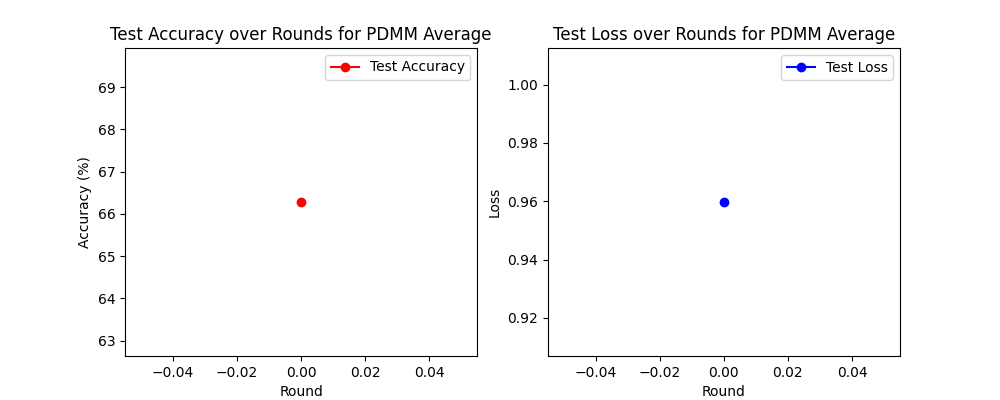

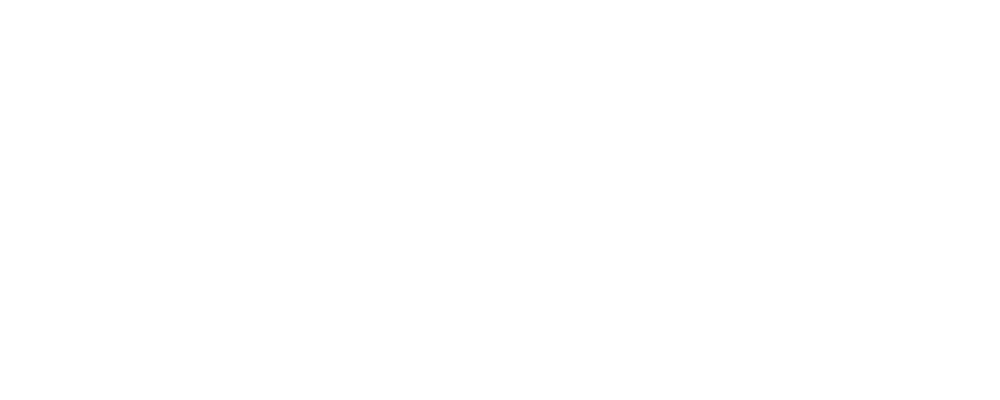

In [123]:
# Lists to keep track of metrics
if save == True:
    log_filename = f"results_log_typeAttack{typeAttack}_PrivacyMethod{PrivacyMethod}_Rounds{num_rounds}.txt"

results = [[] for _ in range(num_rounds)]

if PrivacyMethod != 2:
    for noise_STD in noise_levels:
        global_train_losses = []
        test_losses = []
        test_accuracies = []
        PDMM_error = []
        # test_losses2 = []
        # test_accuracies2 = []
        # test_losses3 = []
        # test_accuracies3 = []
        local_models = copy.deepcopy(local_intialized_models)
        # local_grads  = [None] * num_clients 

        print(f"\n--- Doing noise level {noise_STD} with {num_rounds} rounds---")
        for round in range(num_rounds):
            print(f'\n--- Round {round+1} of {num_rounds} ---')
            
            # Each client trains on its local data
            # local_models = [None] * num_clients
            # print(local_models)
            # for client_idx in range(num_clients):
            #     print(f'\nClient {client_idx+1}/{num_clients} training on local data...')
            #     local_models[client_idx], local_grads[client_idx]= train_local_model(client_datasets[client_idx], local_models[client_idx], num_epochs)

            # Local_models_trained = copy.deepcopy(local_models)
            # Local_models_trained = local_models.copy()

            Local_models_trained = CorruptData(CorruptClients, local_models, typeAttack, var, mean, Target,num_clients,scale)
            # print(global_model)
            # global_model2 = aggregate_models2(Local_models_trained, input_size, hidden_size, num_classes, true_nodes)
            # global_model22 = aggregate_models2(Local_models_trained, input_size, hidden_size, num_classes, all_nodes)

            Local_models_trained, PDMM_error, mask_history = aggregate_models(client_datasets, local_intialized_models, G, tolerance, c, max_iters, rejection_threshold, K_decision, averaging, when, CorruptValue, true_nodes, False, noise_STD, PrivacyMethod, 0, learning_rate)
            # print(global_model)

            # Calculate edges for metrics
            edges = list(G.edges())
            honest_nodes = np.where(CorruptClients == 0)[0]
            lying_nodes = np.where(CorruptClients == 1)[0]

            # Identify target edges
            edges_honest_target = [(i, j) for (i, j) in edges if j in honest_nodes]
            edges_corrupt_target = [(i, j) for (i, j) in edges if j in lying_nodes]

            # Calculate total edges for normalization
            total_honest_edges = len(edges_honest_target)
            total_corrupt_edges = len(edges_corrupt_target)

            # Initialize metrics
            FAR_list = []
            MDR_list = []

            # Calculate metrics for each iteration
            for step in range(len(mask_history)):
                mask = mask_history[step]
                
                # False Alarm Rate (honest edges rejected)
                false_alarms = sum(1 for (i, j) in edges_honest_target if mask[i, j] == -1)
                far = false_alarms / total_honest_edges if total_honest_edges > 0 else 0
                FAR_list.append(far)
                
                # Missed Detection Rate (corrupt edges not rejected)
                missed_detections = sum(1 for (i, j) in edges_corrupt_target if mask[i, j] != -1)
                mdr = missed_detections / total_corrupt_edges if total_corrupt_edges > 0 else 0
                MDR_list.append(mdr)
                
            results[round].append({
                'noise_STD': noise_STD**2,
                'FAR': FAR_list,
                'MDR': MDR_list,
                'Error': PDMM_error
                })
            
            honest_models = [Local_models_trained[i] for i in true_nodes]
            # Evaluate the global model on the test dataset
            test_loss, test_accuracy = evaluate(honest_models, test_dataset, criterion)
            test_losses.append(test_loss)
            test_accuracies.append(test_accuracy)

            # Evaluate the global model on the test dataset
            # test_loss2, test_accuracy2 = evaluate(global_model2, test_dataset, criterion)
            # test_losses2.append(test_loss2)
            # test_accuracies2.append(test_accuracy2)

            # Evaluate the incorrect global model on the test dataset
            # test_loss3, test_accuracy3 = evaluate(global_model22, test_dataset, criterion)
            # test_losses3.append(test_loss3)
            # test_accuracies3.append(test_accuracy3)


            print(f'\nAfter Round {round+1}: Average Test Loss: {test_loss:.4f}, Average Test Accuracy: {test_accuracy:.2f}% for PDMM Average')

            # print(f'\nAfter Round {round+1}: Test Loss: {test_loss2:.4f}, Test Accuracy: {test_accuracy2:.2f}% for True Average')

            # print(f'\nAfter Round {round+1}: Test Loss: {test_loss3:.4f}, Test Accuracy: {test_accuracy3:.2f}% for Incorrect True Average')
            if save == True:
                with open(log_filename, "a") as logfile:
                    logfile.write(f"After Round {round+1}:\n")
                    logfile.write(f"For noise {noise_STD}:\n")
                    logfile.write(f"  PDMM Average -> Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%\n")
                    # logfile.write(f"  True Average -> Test Loss: {test_loss2:.4f}, Test Accuracy: {test_accuracy2:.2f}%\n")
                    # logfile.write(f"  Incorrect True Average -> Test Loss: {test_loss3:.4f}, Test Accuracy: {test_accuracy3:.2f}%\n\n")
            

            # Check stopping criteria
            if test_loss <= threshold:
                print(f'\nLoss threshold reached. Stopping training.')
                break
            # Plot test accuracy and loss over rounds
        plt.figure(figsize=(10, 4))

        # Plot accuracy
        plt.subplot(1, 2, 1)
        plt.plot(range(num_rounds), test_accuracies, 'ro-', label='Test Accuracy')
        plt.title('Test Accuracy over Rounds for PDMM Average')
        plt.xlabel('Round')
        plt.ylabel('Accuracy (%)')
        plt.legend()

        # Plot loss
        plt.subplot(1, 2, 2)
        plt.plot(range(num_rounds), test_losses, 'bo-', label='Test Loss')
        plt.title('Test Loss over Rounds for PDMM Average')
        plt.xlabel('Round')
        plt.ylabel('Loss')
        plt.legend()

        filename_PDMM = f"PDMM_Average_typeAttack{typeAttack}_PrivacyMethod{PrivacyMethod}_noise{noise_STD}_Rounds{num_rounds}.png"
        plt.savefig(filename_PDMM, dpi=300)
        plt.show()

        # Plot test accuracy and loss over rounds
        plt.figure(figsize=(10, 4))

        # Plot accuracy
        # plt.subplot(1, 2, 1)
        # plt.plot(range(num_rounds), test_accuracies2, 'ro-', label='Test Accuracy')
        # plt.title('Test Accuracy over Rounds for True Average')
        # plt.xlabel('Round')
        # plt.ylabel('Accuracy (%)')
        # plt.legend()

        # Plot loss
        # plt.subplot(1, 2, 2)
        # plt.plot(range(num_rounds), test_losses2, 'bo-', label='Test Loss')
        # plt.title('Test Loss over Rounds for True Average')
        # plt.xlabel('Round')
        # plt.ylabel('Loss')
        # plt.legend()

        # filename_True = f"True_Average_typeAttack{typeAttack}_PrivacyMethod{PrivacyMethod}_noise{noise_STD}_Rounds{num_rounds}.png"
        # plt.savefig(filename_True, dpi=300)
        # plt.show()

if PrivacyMethod == 2:
    for p in PrimModulo:
        global_train_losses = []
        test_losses = []
        test_accuracies = []
        PDMM_error = []
        # test_losses2 = []
        # test_accuracies2 = []
        # test_losses3 = []
        # test_accuracies3 = []
        local_models = copy.deepcopy(local_intialized_models)
        print(f"\n--- Doing SMPC with {num_rounds} rounds---")
        for round in range(num_rounds):
            print(f'\n--- Round {round+1} of {num_rounds} ---')
            
            # Each client trains on its local data
            # local_models = [None] * num_clients

            # print(local_models)
            # for client_idx in range(num_clients):
            #     print(f'\nClient {client_idx+1}/{num_clients} training on local data...')
            #     local_models[client_idx]= train_local_model(client_datasets[client_idx], local_models[client_idx], num_epochs)

            # Local_models_trained = copy.deepcopy(local_models)
            # Local_models_trained = local_models.copy()

            Local_models_trained = CorruptData(CorruptClients, Local_models_trained, typeAttack, var, mean, Target,num_clients,scale)
            # print(global_model)
            # global_model2 = aggregate_models2(Local_models_trained, input_size, hidden_size, num_classes, true_nodes)
            # global_model22 = aggregate_models2(Local_models_trained, input_size, hidden_size, num_classes, all_nodes)

            Local_models_trained, PDMM_error, mask_history = aggregate_models(client_datasets, local_intialized_models, G, tolerance, c, max_iters, rejection_threshold, K_decision, averaging, when, CorruptValue, true_nodes, False, 0, PrivacyMethod, p, learning_rate)
            # print(global_model)

            # Calculate edges for metrics
            edges = list(G.edges())
            honest_nodes = np.where(CorruptClients == 0)[0]
            lying_nodes = np.where(CorruptClients == 1)[0]

            # Identify target edges
            edges_honest_target = [(i, j) for (i, j) in edges if j in honest_nodes]
            edges_corrupt_target = [(i, j) for (i, j) in edges if j in lying_nodes]

            # Calculate total edges for normalization
            total_honest_edges = len(edges_honest_target)
            total_corrupt_edges = len(edges_corrupt_target)

            # Initialize metrics
            FAR_list = []
            MDR_list = []

            # Calculate metrics for each iteration
            for step in range(len(mask_history)):
                mask = mask_history[step]
                
                # False Alarm Rate (honest edges rejected)
                false_alarms = sum(1 for (i, j) in edges_honest_target if mask[i, j] == -1)
                far = false_alarms / total_honest_edges if total_honest_edges > 0 else 0
                FAR_list.append(far)
                
                # Missed Detection Rate (corrupt edges not rejected)
                missed_detections = sum(1 for (i, j) in edges_corrupt_target if mask[i, j] != -1)
                mdr = missed_detections / total_corrupt_edges if total_corrupt_edges > 0 else 0
                MDR_list.append(mdr)
                
            results[round].append({
                'FAR': FAR_list,
                'MDR': MDR_list,
                'Error': PDMM_error
                })
            
            honest_models = [Local_models_trained[i] for i in true_nodes]
            # Evaluate the global model on the test dataset
            test_loss, test_accuracy = evaluate(honest_models, test_dataset, criterion)
            test_losses.append(test_loss)
            test_accuracies.append(test_accuracy)

            # # Evaluate the global model on the test dataset
            # test_loss2, test_accuracy2 = evaluate(global_model2, test_dataset, criterion)
            # test_losses2.append(test_loss2)
            # test_accuracies2.append(test_accuracy2)

            # # Evaluate the incorrect global model on the test dataset
            # test_loss3, test_accuracy3 = evaluate(global_model22, test_dataset, criterion)
            # test_losses3.append(test_loss3)
            # test_accuracies3.append(test_accuracy3)


            print(f'\nAfter Round {round+1}: Average Test Loss: {test_loss:.4f}, Average Test Accuracy: {test_accuracy:.2f}% for PDMM Average')

            # print(f'\nAfter Round {round+1}: Test Loss: {test_loss2:.4f}, Test Accuracy: {test_accuracy2:.2f}% for True Average')

            # print(f'\nAfter Round {round+1}: Test Loss: {test_loss3:.4f}, Test Accuracy: {test_accuracy3:.2f}% for Incorrect True Average')
            if save == True:
                with open(log_filename, "a") as logfile:
                    logfile.write(f"After Round {round+1}:\n")
                    logfile.write(f"For SMPC:\n")
                    logfile.write(f"  PDMM Average -> Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%\n")
                    # logfile.write(f"  True Average -> Test Loss: {test_loss2:.4f}, Test Accuracy: {test_accuracy2:.2f}%\n")
                    # logfile.write(f"  Incorrect True Average -> Test Loss: {test_loss3:.4f}, Test Accuracy: {test_accuracy3:.2f}%\n\n")
            

            # Check stopping criteria
            if test_loss <= threshold:
                print(f'\nLoss threshold reached. Stopping training.')
                break
            # Plot test accuracy and loss over rounds
        plt.figure(figsize=(10, 4))

        # Plot accuracy
        plt.subplot(1, 2, 1)
        plt.plot(range(num_rounds), test_accuracies, 'ro-', label='Test Accuracy')
        plt.title('Test Accuracy over Rounds for PDMM Average')
        plt.xlabel('Round')
        plt.ylabel('Accuracy (%)')
        plt.legend()

        # Plot loss
        plt.subplot(1, 2, 2)
        plt.plot(range(num_rounds), test_losses, 'bo-', label='Test Loss')
        plt.title('Test Loss over Rounds for PDMM Average')
        plt.xlabel('Round')
        plt.ylabel('Loss')
        plt.legend()

        filename_PDMM = f"PDMM_Average_typeAttack{typeAttack}_PrivacyMethod{PrivacyMethod}_SMPC_Rounds{num_rounds}.png"
        plt.savefig(filename_PDMM, dpi=300)
        plt.show()

        # Plot test accuracy and loss over rounds
        plt.figure(figsize=(10, 4))

        # # Plot accuracy
        # plt.subplot(1, 2, 1)
        # plt.plot(range(num_rounds), test_accuracies2, 'ro-', label='Test Accuracy')
        # plt.title('Test Accuracy over Rounds for True Average')
        # plt.xlabel('Round')
        # plt.ylabel('Accuracy (%)')
        # plt.legend()

        # # Plot loss
        # plt.subplot(1, 2, 2)
        # plt.plot(range(num_rounds), test_losses2, 'bo-', label='Test Loss')
        # plt.title('Test Loss over Rounds for True Average')
        # plt.xlabel('Round')
        # plt.ylabel('Loss')
        # plt.legend()

        # filename_True = f"True_Average_typeAttack{typeAttack}_PrivacyMethod{PrivacyMethod}_SMPC_Rounds{num_rounds}.png"
        # plt.savefig(filename_True, dpi=300)
        # plt.show()




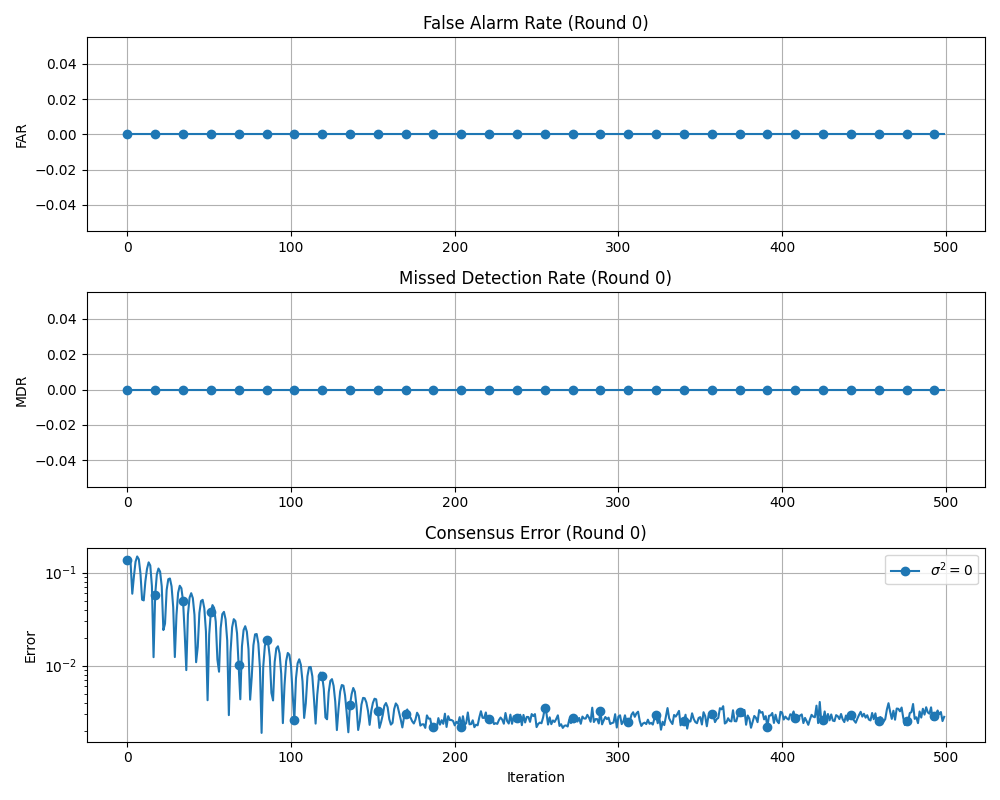

In [124]:
for round in range(num_rounds):
    plot_combined_metrics(results[round], round, typeAttack, PrivacyMethod, save)